In [1]:
""" Inflation Prediction Study
Author: Camilla Nore
Date:   2015-08-30
"""
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

%matplotlib notebook
#%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# NB: As this is iPython, the module will be cached. If you change 
#     the module, you have to restart the iPython kernel.
from inflastudy import InflaData  # Custom module for this study.
from inflastudy import decode_column_name # Decode column name

<IPython.core.display.Javascript object>


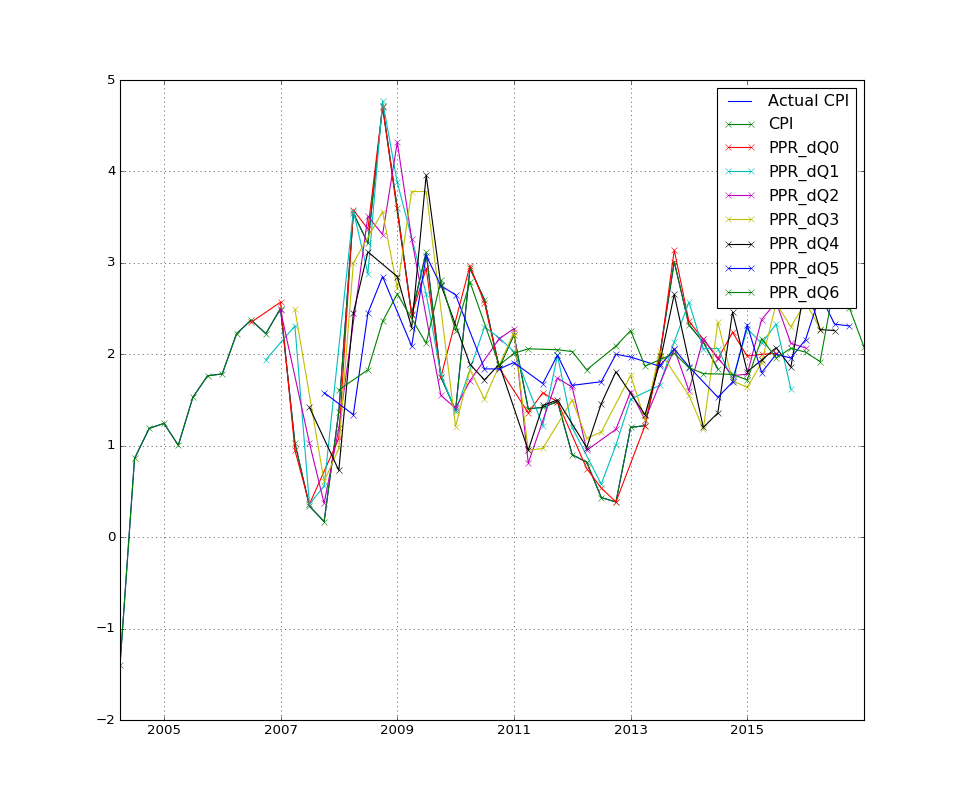

In [2]:
""" Load the data file"""

data = InflaData.InflaData(filename='data/kongepanel_upd_ark_A.csv')
data.remap_to_relative_time(prediction_horizon=16)
data.plot_relative_time_cpi_data()
#print data.raw_data.CPI       # Uncomment this line to see raw CPI data.
#print data.raw_data.columns   # Uncomment this line to see column names.

In [ ]:
""" What is the prediction error as a function of prediction horizon. """

# Empty dataframe for error
data.cpi_pred_error = pd.DataFrame(index=data.cpi_pred_relative.index)

# Loop the cpi predictions
for i, col_name in enumerate(data.cpi_pred_relative.columns):
    if 'CPI' in col_name:  # Skip the CPI column
        continue
    err_name = col_name + '_err'
    data.cpi_pred_error[err_name] = (
        data.cpi_pred_relative[col_name] - data.cpi_pred_relative.CPI)
#print(data.cpi_pred_error.columns)
selected_columns = ['PPR_dQ2_err', 'PPR_dQ4_err', 'PPR_dQ8_err', 'PPR_dQ12_err',]
# Plot the error data, with connected lines
for i, col_name in enumerate(data.cpi_pred_error):
    only_valid_data = np.isfinite(data.cpi_pred_error[col_name])
    if col_name in selected_columns:
        style = '-'
        label = col_name
    else:
        style = '--'
        label = None
        continue #If we want to completely skip these.
    plt.plot(data.cpi_pred_error.index[only_valid_data],
         data.cpi_pred_error.loc[only_valid_data,col_name],
         style, label=label)
plt.title('Error data')
plt.grid()
plt.legend()

# Find the mean, squaremean and std of the error.
pred_error_sqmean = data.cpi_pred_error.apply(np.square).apply(np.mean)
pred_error_mean = data.cpi_pred_error.apply(np.mean)
pred_error_rmse = np.sqrt(pred_error_sqmean)
pred_error_std = data.cpi_pred_error.apply(np.std)
horizon_range = range(1,len(pred_error_sqmean.index)+1)
print('pred error std', pred_error_std)

plt.figure('Mean of square error')
plt.title('Mean of square error')
plt.errorbar(horizon_range,           # The x-axis
             pred_error_sqmean[:],   # The line
             yerr=pred_error_std)     # The error bars
plt.xlabel('Prediction horizon in quarters')
plt.grid()
plt.figure('Root of mean square error')
plt.title('Root of mean square error')
plt.errorbar(horizon_range,           # The x-axis
             pred_error_rmse[:],   # The line
             yerr=pred_error_std)     # The error bars
plt.xlabel('Prediction horizon in quarters')
plt.grid()
plt.figure('Mean of error')
plt.title('Mean of error')
plt.errorbar(horizon_range,           # The x-axis
             pred_error_mean[:],   # The line
             yerr=pred_error_std)     # The error bars
plt.xlabel('Prediction horizon in quarters')
plt.grid()


In [ ]:
# Export the data to csv.
data.cpi_pred_error.to_excel('pred_error.xlsx')

In [ ]:
""" Plot all CPI predictions and the actual CPI. """

plt.figure('CPI predictions', figsize=(10,8))  # Larger plot.
plt.title('CPI predictions')
plt.xlabel('Year')
# Plot the actual CPI as a solid line.
plt.plot(data.raw_data.index,
         data.raw_data['CPI'],
         label ='CPI')

for col_name in data.cpi_predictions:
    plt.plot(data.cpi_predictions.index,
             data.cpi_predictions[col_name],
             '--',
             label = 'col_name')

In [ ]:
""" Plot all CPI-jae predictions and the actual CPI-jae. """

plt.figure('CPI jae predictions', figsize=(10,8))  # Larger plot.
plt.title('CPI jae predictions')
plt.xlabel('Year')

# Plot the actual CPI as a solid line.
plt.plot(data.raw_data.index,
         data.raw_data['CPI-jae'],
         label ='CPI jae')

for col_name in data.cpi_jae_predictions:
    plt.plot(data.cpi_jae_predictions.index,
             data.cpi_jae_predictions[col_name],
             '--',
             label = 'col_name')


In [ ]:
"""Get a naive linear trajectory"""
    #Remember: current CPI might not be available at time h = 0, might need to use h - 1. 
def get_naive_trajectory(current_value, target_value = 2.5, mode='linear', horizon_quarters=12):
    cpi_naive_trajectory = [current_value]
    for h in range(1,horizon_quarters+1):
        if mode == 'linear':
            cpi_naive_forecast = current_value + h/horizon_quarters*(target_value - current_value)
        elif mode == 'exp':
            # This might be better for longer horizons to avoid overshoot.
            cpi_naive_forecast = current_value + (target_value-current_value)*np.exp(-1/h)
        cpi_naive_trajectory.append(cpi_naive_forecast)
    return cpi_naive_trajectory

current_value = 4.0
cpi_naive_trajectory = get_naive_trajectory(current_value)
print(cpi_naive_trajectory)

plt.plot(cpi_naive_trajectory)
plt.plot(get_naive_trajectory(current_value, mode='exp'))

In [ ]:
# Test the InflaData class

import numpy as np
import nose.tools
from inflastudy import InflaData
k_first_t_in_data = '2006-03-31'
k_test_data = 'tests/test_data_input.csv'


def test_init():
    """ Test creating an empty object"""
    data = InflaData.InflaData()
    assert data is not None


def test_init_with_data():
    """ Test loading data_file. """
    data = InflaData.InflaData(k_test_data)
    # Verify that the first line of data is read correctly.
    nose.tools.eq_(data.raw_data.index[0],
                   np.datetime64(k_first_t_in_data),
                   'First line date does not match')
    print('Successfully loaded test data: \n', data.raw_data)
    
test_init_with_data()

In [ ]:
testdata = InflaData.InflaData(filename='tests/test_data_input.csv')
testdata.remap_to_relative_time()
print(testdata.raw_data)
print(testdata.cpi_pred_relative)